# 1.1. Data set up

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
from scipy.stats import loguniform
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import classification_report, r2_score, mean_squared_error
from warnings import filterwarnings
filterwarnings(action='ignore')
%matplotlib inline   
%load_ext blackcellmagic

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("float_format", "{:.2f}".format)

In [3]:
england_df = pd.read_csv('final_table.csv')
england_df.head()

,country_id,league_name,season,game_date,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,home_team_goal,away_team_goal,home_team_points,away_team_points,result_by_home_team,home_team_goals_last_game,home_team_conceded_goals_last_game,away_team_goal_last_game,away_team_conceded_goals_last_game,home_team_points_last_game,away_team_points_last_game,avg_home_team_goals_by_season_per_game,avg_home_team_goals_in_total_per_game,avg_home_team_conceded_goals_by_season_per_game,avg_home_team_conceded_goals_in_total_per_game,avg_home_team_goals_per_last_3_games,avg_home_team_conceded_goals_per_last_3_games,avg_away_team_goals_by_season_per_game,avg_away_team_goals_in_total_per_game,avg_away_team_conceded_goals_by_season_per_game,avg_away_team_conceded_goals_in_total_per_game,avg_away_team_goals_per_last_3_games,avg_away_team_conceded_goals_per_last_3_games,sum_home_points_by_season_until_this_game,sum_away_points_by_season_until_this_game,avg_home_shot_on,avg_home_shot_off,avg_away_shot_on,avg_away_shot_off,home_chanceCreationPassing,home_chanceCreationCrossing,home_chanceCreationShooting,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth
0,1729,England Premier League,2008/2009,2008-08-16,489043,9825,Arsenal,8659,West Bromwich Albion,1,0,3,0,3,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,7.44,6.55,5.55,5.68,34.67,46.33,46.50,50.50,46.50,50.50,53.00,56.00,54.67,43.00,45.67,54.83
1,1729,England Premier League,2008/2009,2008-08-16,489044,8472,Sunderland,8650,Liverpool,0,1,0,3,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.04,5.44,7.72,7.23,56.67,55.33,59.00,43.67,52.17,51.83,41.33,47.83,57.33,51.00,52.50,56.00
2,1729,England Premier League,2008/2009,2008-08-16,489045,8654,West Ham United,8528,Wigan Athletic,2,1,3,0,3,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.78,5.76,6.01,6.16,50.33,65.50,40.50,32.50,42.83,40.17,52.67,55.50,45.50,50.00,54.00,46.00
3,1729,England Premier League,2008/2009,2008-08-16,489047,8668,Everton,8655,Blackburn Rovers,2,3,0,3,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,6.55,5.80,5.39,5.23,48.17,58.00,49.83,48.33,57.50,56.33,57.00,56.00,42.00,45.67,55.00,46.67
4,1729,England Premier League,2008/2009,2008-08-16,489048,8549,Middlesbrough,8586,Tottenham Hotspur,2,1,3,0,3,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.54,6.14,7.67,6.84,51.00,59.50,56.00,39.33,47.00,42.83,49.83,59.33,62.33,51.17,50.00,55.00


# 2. Predicting the football match result 

## 2.1. Assumptions for logistic regression

* 1. *Appropriate outcome type*

The dependent variable from - result_by_home_team is a categorical variable with total 3 outcomes:
* 3 - win;
* 1 - draw;
* 0 - loss.

* 2.  *Sufficiently large sample size*

Total number of observations should be greater than 500 and it is so, total number of observations: 3040.

In [5]:
len(england_df)

3040

* 3. *Absence of multicollinearity*

There are no multicollinearity bertween independent variables. 
Multicollinearity occurs when you have two or more independent variables that are highly correlated with each other. Multicollinearity, if left unchecked, can raise the variance of coefficient estimates, leading to larger confidence intervals. This makes it more difficult to obtain statistically significant results from any subsequent analysis, [more on this here](https://towardsdatascience.com/targeting-multicollinearity-with-python-3bd3b4088d0b). 

In this scenario, I assumed that any features with a correlation coefficient exceeding 0.80 are suspected of causing multicollinearity. From EDA in chapter 3.3. and the heatmap of Pearson's correlation coefficients we see that no features, that I will use in modeling, correlation coefficients reach or exceed 0.8.

In [4]:
england_df.head()

,country_id,league_name,season,game_date,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,home_team_goal,away_team_goal,home_team_points,away_team_points,result_by_home_team,home_team_goals_last_game,home_team_conceded_goals_last_game,away_team_goal_last_game,away_team_conceded_goals_last_game,home_team_points_last_game,away_team_points_last_game,avg_home_team_goals_by_season_per_game,avg_home_team_goals_in_total_per_game,avg_home_team_conceded_goals_by_season_per_game,avg_home_team_conceded_goals_in_total_per_game,avg_home_team_goals_per_last_3_games,avg_home_team_conceded_goals_per_last_3_games,avg_away_team_goals_by_season_per_game,avg_away_team_goals_in_total_per_game,avg_away_team_conceded_goals_by_season_per_game,avg_away_team_conceded_goals_in_total_per_game,avg_away_team_goals_per_last_3_games,avg_away_team_conceded_goals_per_last_3_games,sum_home_points_by_season_until_this_game,sum_away_points_by_season_until_this_game,avg_home_shot_on,avg_home_shot_off,avg_away_shot_on,avg_away_shot_off,home_chanceCreationPassing,home_chanceCreationCrossing,home_chanceCreationShooting,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth
0,1729,England Premier League,2008/2009,2008-08-16,489043,9825,Arsenal,8659,West Bromwich Albion,1,0,3,0,3,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,7.44,6.55,5.55,5.68,34.67,46.33,46.50,50.50,46.50,50.50,53.00,56.00,54.67,43.00,45.67,54.83
1,1729,England Premier League,2008/2009,2008-08-16,489044,8472,Sunderland,8650,Liverpool,0,1,0,3,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.04,5.44,7.72,7.23,56.67,55.33,59.00,43.67,52.17,51.83,41.33,47.83,57.33,51.00,52.50,56.00
2,1729,England Premier League,2008/2009,2008-08-16,489045,8654,West Ham United,8528,Wigan Athletic,2,1,3,0,3,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.78,5.76,6.01,6.16,50.33,65.50,40.50,32.50,42.83,40.17,52.67,55.50,45.50,50.00,54.00,46.00
3,1729,England Premier League,2008/2009,2008-08-16,489047,8668,Everton,8655,Blackburn Rovers,2,3,0,3,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,6.55,5.80,5.39,5.23,48.17,58.00,49.83,48.33,57.50,56.33,57.00,56.00,42.00,45.67,55.00,46.67
4,1729,England Premier League,2008/2009,2008-08-16,489048,8549,Middlesbrough,8586,Tottenham Hotspur,2,1,3,0,3,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.54,6.14,7.67,6.84,51.00,59.50,56.00,39.33,47.00,42.83,49.83,59.33,62.33,51.17,50.00,55.00


In [5]:
# Calculating Variance Inflation Factor (VIF)
df_result = england_df.copy()
df_result.drop(
    columns=[
        "country_id",
        "league_name",
        "season",
        "game_date",
        "match_api_id",
        "home_team_api_id",
        "home_team",
        "away_team_api_id",
        "away_team",
        "home_team_goal",
        "away_team_goal",
        "home_team_points",
        "away_team_points",
    ],
    axis=1,
    inplace=True,
)
X_temp = df_result.drop(["result_by_home_team"], axis=1)
Xtemp_constant = add_constant(X_temp)


def calc_vif(df_result):
    vif = pd.DataFrame()
    vif["variables"] = df_result.columns
    vif["VIF"] = [
        variance_inflation_factor(df_result.values, i)
        for i in range(df_result.shape[1])
    ]
    return vif


calc_vif(Xtemp_constant)  # Include constant in VIF calculation in Python

,variables,VIF
0,const,1722.55
1,home_team_goals_last_game,3.04
2,home_team_conceded_goals_last_game,2.82
3,away_team_goal_last_game,3.15
4,away_team_conceded_goals_last_game,2.64
5,home_team_points_last_game,3.60
6,away_team_points_last_game,3.57
7,avg_home_team_goals_by_season_per_game,2.94
8,avg_home_team_goals_in_total_per_game,3.35
9,avg_home_team_conceded_goals_by_season_per_game,2.37


The threshold for VIF is usually 5 (i.e. values above 5 means there is presence of multicollinearity)
- avg_home_shot_on:	9.35;
- avg_home_shot_off:	10.28;
- avg_away_shot_on:	9.03;
- avg_away_shot_off:	9.62;

So these variables do not satisfy this assumption (but still is near 10), so later it can be considered to remove highly correlated predictors from the model. 

* 4.  *Independence of observations*

All the observations in this data set are independent, every observation is a single match, where play two different teams, on different days and even seasons.

* 5. *Linear relationship between any continuous independent variables and the logit transformation of the dependent variable.*

One of the critical assumptions of logistic regression is that the relationship between the logit (aka log-odds) of the outcome and each continuous independent variable is linear.

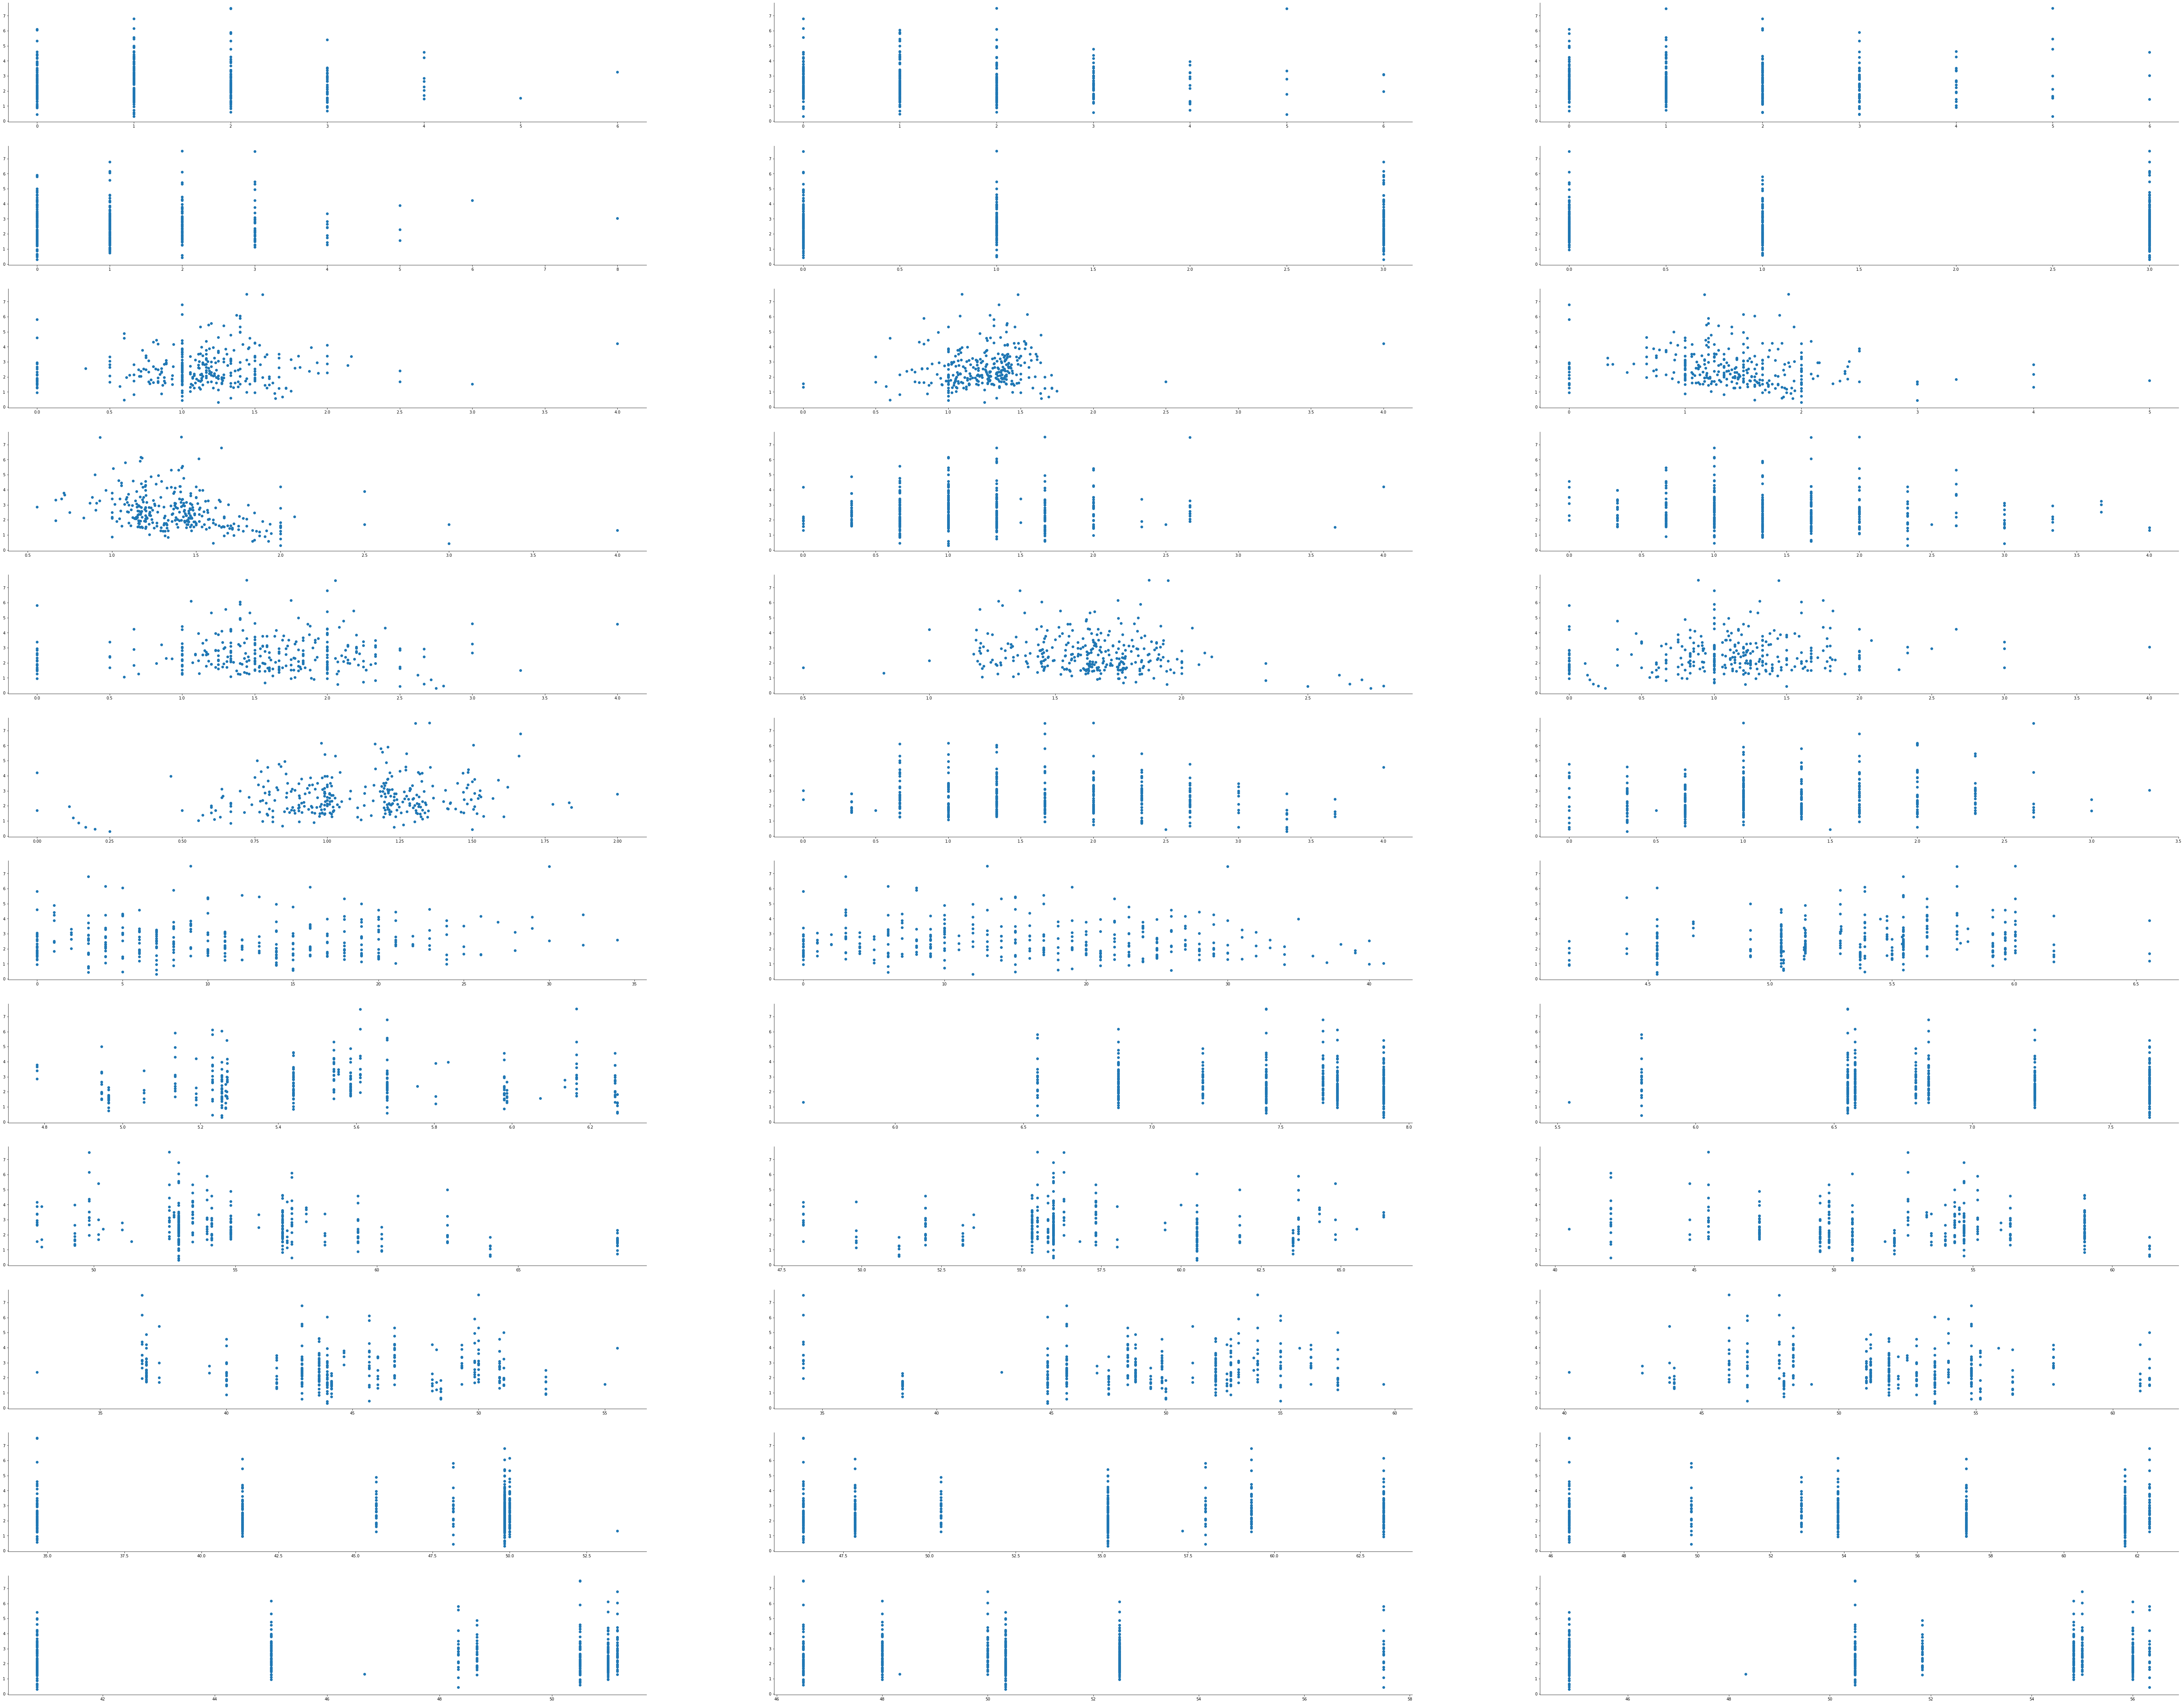

In [6]:
# Re-running logistic regression on the original set of X and y variables
y_temp = df_result.result_by_home_team
logit_results = sm.GLM(y_temp, Xtemp_constant, family=sm.families.Poisson()).fit()
predicted = logit_results.predict(Xtemp_constant)

# Getting log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor variable vs logit values for all columns:
plt.figure(figsize=(100, 80))
cmap = sns.diverging_palette(250, 20, as_cmap=True)

for i in range(1, len(X_temp.columns) + 1):
    plt.subplot(12, 3, i)
    ax = plt.scatter(x=X_temp[X_temp.columns[i - 1]].values, y=log_odds)
    sns.despine(right=True, left=False)
plt.show()

I actually don't see linearity in these scatter plots, mostly the pattern is mixed. So there might be problem with fitting logistic regression.

* 6. *No strongly influential outliers*

There are lot of outliers, as we see from the box plots in the EDA chapter 3.3. I decided to drop outliers in the standardized data later in the modeling.

## 2.2. Feature pre-processing

In [7]:
# The data set is already ordered by game_date - ascending order.
result_subset = england_df.copy()
result_subset.head()

,country_id,league_name,season,game_date,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,home_team_goal,away_team_goal,home_team_points,away_team_points,result_by_home_team,home_team_goals_last_game,home_team_conceded_goals_last_game,away_team_goal_last_game,away_team_conceded_goals_last_game,home_team_points_last_game,away_team_points_last_game,avg_home_team_goals_by_season_per_game,avg_home_team_goals_in_total_per_game,avg_home_team_conceded_goals_by_season_per_game,avg_home_team_conceded_goals_in_total_per_game,avg_home_team_goals_per_last_3_games,avg_home_team_conceded_goals_per_last_3_games,avg_away_team_goals_by_season_per_game,avg_away_team_goals_in_total_per_game,avg_away_team_conceded_goals_by_season_per_game,avg_away_team_conceded_goals_in_total_per_game,avg_away_team_goals_per_last_3_games,avg_away_team_conceded_goals_per_last_3_games,sum_home_points_by_season_until_this_game,sum_away_points_by_season_until_this_game,avg_home_shot_on,avg_home_shot_off,avg_away_shot_on,avg_away_shot_off,home_chanceCreationPassing,home_chanceCreationCrossing,home_chanceCreationShooting,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth
0,1729,England Premier League,2008/2009,2008-08-16,489043,9825,Arsenal,8659,West Bromwich Albion,1,0,3,0,3,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,7.44,6.55,5.55,5.68,34.67,46.33,46.50,50.50,46.50,50.50,53.00,56.00,54.67,43.00,45.67,54.83
1,1729,England Premier League,2008/2009,2008-08-16,489044,8472,Sunderland,8650,Liverpool,0,1,0,3,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.04,5.44,7.72,7.23,56.67,55.33,59.00,43.67,52.17,51.83,41.33,47.83,57.33,51.00,52.50,56.00
2,1729,England Premier League,2008/2009,2008-08-16,489045,8654,West Ham United,8528,Wigan Athletic,2,1,3,0,3,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.78,5.76,6.01,6.16,50.33,65.50,40.50,32.50,42.83,40.17,52.67,55.50,45.50,50.00,54.00,46.00
3,1729,England Premier League,2008/2009,2008-08-16,489047,8668,Everton,8655,Blackburn Rovers,2,3,0,3,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,6.55,5.80,5.39,5.23,48.17,58.00,49.83,48.33,57.50,56.33,57.00,56.00,42.00,45.67,55.00,46.67
4,1729,England Premier League,2008/2009,2008-08-16,489048,8549,Middlesbrough,8586,Tottenham Hotspur,2,1,3,0,3,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.54,6.14,7.67,6.84,51.00,59.50,56.00,39.33,47.00,42.83,49.83,59.33,62.33,51.17,50.00,55.00


In [8]:
england_subset = england_df.copy()
# Identify and drop our target variable 'result_by_home_team' from dataframe, isolating our independent variables, which all are numeric
X = england_subset.drop('result_by_home_team', axis = 1)
cols = X.columns
# Isolate our dependent variable as a feature
y = england_subset.result_by_home_team

As I have data, ordered by the match date and the order is important, not to give predict on future matche's data,
I split dataset manually:test set - data from last season 2015/2016, train set - all previous seasons. Drop unneeded columns after splitting.

In [9]:
# Splitting the data into train and test sets.

X_test = X[X["season"] == "2015/2016"]
X_test.drop(
    columns=[
        "country_id",
        "league_name",
        "season",
        "game_date",
        "match_api_id",
        "home_team_api_id",
        "home_team",
        "away_team_api_id",
        "away_team",
        "home_team_goal",
        "away_team_goal",
        "home_team_points",
        "away_team_points",
    ],
    axis=1,
    inplace=True,
)
y_test = y.iloc[2660:]
y_test.head()
X_train = X[X["season"] != "2015/2016"]
X_train.drop(
    columns=[
        "country_id",
        "league_name",
        "season",
        "game_date",
        "match_api_id",
        "home_team_api_id",
        "home_team",
        "away_team_api_id",
        "away_team",
        "home_team_goal",
        "away_team_goal",
        "home_team_points",
        "away_team_points",
    ],
    axis=1,
    inplace=True,
)
y_train = y.iloc[:2660]
y_train.tail()

2655    1
2656    3
2657    3
2658    3
2659    3
Name: result_by_home_team, dtype: int64

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2660, 36)
(380, 36)
(2660,)
(380,)


## 2.3. Logistic multinomial regression (standardized data)

* As I wanted to standardize data and to use cross validation, also I acknowledge this data as a type of time series, as the future data of the matches cannot be given to predict earlier outcomes, I got a problem how to standardize data without showing test data (of the cross validation folders) to the model. So I decided to use pipeline, which deals with this problem.

* Searching for hyperparameters to the model.

In [11]:
# delete unneeded columns from X and y.
X_temp = X.copy()
X_temp.drop(
    columns=[
        "country_id",
        "league_name",
        "season",
        "game_date",
        "match_api_id",
        "home_team_api_id",
        "home_team",
        "away_team_api_id",
        "away_team",
        "home_team_goal",
        "away_team_goal",
        "home_team_points",
        "away_team_points",
    ],
    axis=1,
    inplace=True,
)
y_temp = y.copy()
y_temp.drop(
    columns=[
        "country_id",
        "league_name",
        "season",
        "game_date",
        "match_api_id",
        "home_team_api_id",
        "home_team",
        "away_team_api_id",
        "away_team",
        "home_team_goal",
        "away_team_goal",
        "home_team_points",
        "away_team_points",
    ],
    axis=1,
    inplace=True,
)

# define model
model = LogisticRegression(multi_class="multinomial")

# define evaluation
cv = TimeSeriesSplit(
    n_splits=8,
    gap=0,
    max_train_size=None,
    test_size=None,
)
# define search space
space = dict()
space["solver"] = ["newton-cg", "lbfgs", "sag", "saga"]
space["penalty"] = ["none", "l1", "l2", "elasticnet"]
space["C"] = loguniform(1e-5, 100)

# define search
search = RandomizedSearchCV(
    model, space, n_iter=500, scoring="accuracy", n_jobs=-1, cv=cv, random_state=1
)
# execute search
result = search.fit(X_temp, y_temp)
# summarize result
print("Best Score: %s" % result.best_score_)
print("Best Hyperparameters: %s" % result.best_params_)

Best Score: 0.5137240356083086
Best Hyperparameters: {'C': 0.17551176416426145, 'penalty': 'l1', 'solver': 'saga'}


In [12]:
classifier = LogisticRegression(C= 0.17551176416426145, penalty= 'l1', solver= 'saga', multi_class='multinomial')
model = make_pipeline(StandardScaler(), classifier)
scores = cross_val_score(model, X_train, y_train, cv=cv)
print(f'Accuracy on train data: {scores.mean()}')

Accuracy on train data: 0.5300847457627118


In [13]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.17551176416426145,
                                    multi_class='multinomial', penalty='l1',
                                    solver='saga'))])

In [14]:
intercept = model.named_steps['logisticregression'].intercept_
intercept

array([-0.19831743, -0.17504873,  0.37336616])

In [15]:
# Get the coefficients of each feature
coefs = model.named_steps["logisticregression"].coef_

# Zip coefficients and names together and make a DataFrame
zipped = zip(X_train.columns, coefs[0], coefs[1], coefs[2])
df_coef = pd.DataFrame(
    zipped, columns=["feature", "coefficientloss", "coefficientdraw", "coefficientwin"]
)
df_coef

,feature,coefficientloss,coefficientdraw,coefficientwin
0,home_team_goals_last_game,0.00,-0.05,0.02
1,home_team_conceded_goals_last_game,0.01,0.00,-0.04
2,away_team_goal_last_game,0.00,0.00,0.00
3,away_team_conceded_goals_last_game,0.03,0.00,-0.00
4,home_team_points_last_game,0.00,0.01,-0.11
5,away_team_points_last_game,-0.03,0.00,0.02
6,avg_home_team_goals_by_season_per_game,0.00,-0.00,0.05
7,avg_home_team_goals_in_total_per_game,0.00,0.00,0.11
8,avg_home_team_conceded_goals_by_season_per_game,0.00,0.00,-0.01
9,avg_home_team_conceded_goals_in_total_per_game,0.04,0.00,-0.17


In [16]:
# Generate model prediction data for train and test sets (standardized)
y_hat_train_log = model.predict(X_train)
y_hat_test_log = model.predict(X_test)

* Evaluating Model Performance

Accuracy on Train (standardized) Data: 53.42%


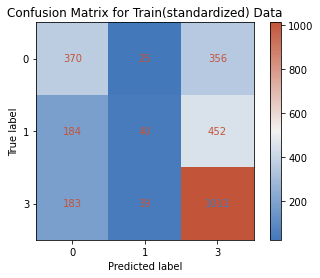

              precision    recall  f1-score   support

           0       0.50      0.49      0.50       751
           1       0.38      0.06      0.10       676
           3       0.56      0.82      0.66      1233

    accuracy                           0.53      2660
   macro avg       0.48      0.46      0.42      2660
weighted avg       0.50      0.53      0.47      2660




In [17]:
# on train data.
y_hat_train_log
accuracy = accuracy_score(y_train, y_hat_train_log)
print(f"Accuracy on Train (standardized) Data: {accuracy*100:.2f}%")


cmap = sns.diverging_palette(250, 20, as_cmap=True)
plot_confusion_matrix(model, X_train, y_train, cmap=cmap)
plt.title("Confusion Matrix for Train(standardized) Data")
plt.show()
print(classification_report(y_train, y_hat_train_log))

print()

Accuracy on Test Data: 46.58%


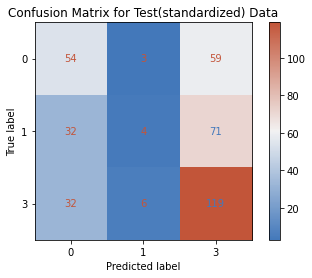

              precision    recall  f1-score   support

           0       0.46      0.47      0.46       116
           1       0.31      0.04      0.07       107
           3       0.48      0.76      0.59       157

    accuracy                           0.47       380
   macro avg       0.41      0.42      0.37       380
weighted avg       0.42      0.47      0.40       380




In [18]:
# on test data.

y_hat_test_log
accuracy = accuracy_score(y_test, y_hat_test_log)
print(f"Accuracy on Test Data: {accuracy*100:.2f}%")


cmap = sns.diverging_palette(250, 20, as_cmap=True)
plot_confusion_matrix(model, X_test, y_test, cmap=cmap)
plt.title("Confusion Matrix for Test(standardized) Data")
plt.show()
print(classification_report(y_test, y_hat_test_log))

print()

Model doesn't do good on new test  data. It seems underfitting and the coefficients of all features are very low.

## 2.4. Logistic multinomial regression (without outliers and standardized data)

In [19]:
# Removing the outliers from X_train.
X_train_outl = X_train[(np.abs(stats.zscore(X_train)) < 2.5).all(axis=1)]
# Set y-train  to only include entries which correspond with X_train (remove outliers)
y_train_outl = y_train.loc[X_train_outl.index]

In [21]:
classifier = LogisticRegression(
    C= 0.17551176416426145, penalty= 'l1', solver= 'saga', multi_class='multinomial'
)
model2 = make_pipeline(StandardScaler(), classifier)
scores2 = cross_val_score(model2, X_train_outl, y_train_outl, cv=cv)
print(f"Accuracy on train data without outliers: {scores.mean()}")

Accuracy on train data without outliers: 0.5300847457627118


In [22]:
model2.fit(X_train_outl, y_train_outl)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.17551176416426145,
                                    multi_class='multinomial', penalty='l1',
                                    solver='saga'))])

In [23]:
# Generate model prediction data for train and test sets (standardized without outliers).
y_hat_train_log2 = model2.predict(X_train_outl)
y_hat_test_log2 = model2.predict(X_test)

Accuracy on Train (standardized without outliers) Data: 52.55%


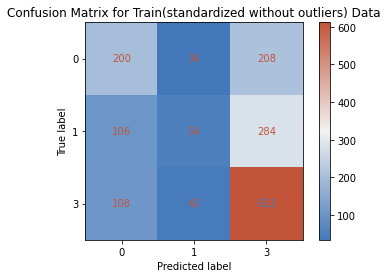

              precision    recall  f1-score   support

           0       0.48      0.45      0.47       442
           1       0.42      0.12      0.19       444
           3       0.55      0.80      0.66       762

    accuracy                           0.53      1648
   macro avg       0.48      0.46      0.44      1648
weighted avg       0.50      0.53      0.48      1648




In [24]:
# on train data without outliers.
y_hat_train_log2
accuracy = accuracy_score(y_train_outl, y_hat_train_log2)
print(f"Accuracy on Train (standardized without outliers) Data: {accuracy*100:.2f}%")


cmap = sns.diverging_palette(250, 20, as_cmap=True)
plot_confusion_matrix(model2, X_train_outl, y_train_outl, cmap=cmap)
plt.title("Confusion Matrix for Train(standardized without outliers) Data")
plt.show()
print(classification_report(y_train_outl, y_hat_train_log2))

print()

Accuracy on Test Data: 46.32%


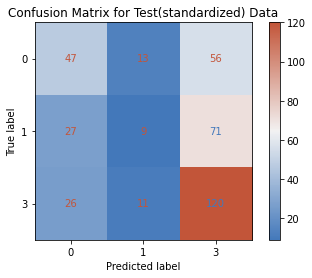

              precision    recall  f1-score   support

           0       0.47      0.41      0.44       116
           1       0.27      0.08      0.13       107
           3       0.49      0.76      0.59       157

    accuracy                           0.46       380
   macro avg       0.41      0.42      0.39       380
weighted avg       0.42      0.46      0.41       380




In [25]:
# on test data, when trained without outliers.

y_hat_test_log2
accuracy = accuracy_score(y_test, y_hat_test_log2)
print(f"Accuracy on Test Data: {accuracy*100:.2f}%")


cmap = sns.diverging_palette(250, 20, as_cmap=True)
plot_confusion_matrix(model2, X_test, y_test, cmap=cmap)
plt.title("Confusion Matrix for Test(standardized) Data")
plt.show()
print(classification_report(y_test, y_hat_test_log2))

print()

Even model was trained without outliers, test data was the same and we got exactly the same accuracy score on test data.

## 2.5. Logistic multinomial regression (with selected features only, standardized)

In [2]:
X_train_less = X_train.copy().drop(
    columns=[
        "away_team_conceded_goals_last_game",
        "away_team_goal_last_game",
        "away_team_conceded_goals_last_game",
        "avg_home_team_conceded_goals_by_season_per_game",
        "avg_home_team_goals_per_last_3_games",
        "sum_away_points_by_season_until_this_game",
        "avg_home_shot_off",
        "avg_away_shot_off",
        "home_chanceCreationPassing",
        "home_defencePressure",
        "home_defenceAggression",
        "home_defenceTeamWidth",
        "away_chanceCreationPassing",
        "away_chanceCreationShooting",
        "away_defenceAggression",
    ],
    axis=1,
)
len(X_train_less.columns)

In [3]:
X_test_less = X_test.copy().drop(
    columns=[
        "away_team_conceded_goals_last_game",
        "away_team_goal_last_game",
        "away_team_conceded_goals_last_game",
        "avg_home_team_conceded_goals_by_season_per_game",
        "avg_home_team_goals_per_last_3_games",
        "sum_away_points_by_season_until_this_game",
        "avg_home_shot_off",
        "avg_away_shot_off",
        "home_chanceCreationPassing",
        "home_defencePressure",
        "home_defenceAggression",
        "home_defenceTeamWidth",
        "away_chanceCreationPassing",
        "away_chanceCreationShooting",
        "away_defenceAggression",
    ],
    axis=1,
)

In [29]:
classifier = LogisticRegression(
    C=0.17551176416426145, penalty="l1", solver="saga", multi_class="multinomial"
)
model3 = make_pipeline(StandardScaler(), classifier)
scores3 = cross_val_score(model3, X_train_less, y_train, cv=cv)
print(f"Accuracy on train data: {scores3.mean()}")
model3.fit(X_train_less, y_train)

# Generate model prediction data for train and test sets (standardized)
y_hat_train_log3 = model3.predict(X_train_less)
y_hat_test_log3 = model3.predict(X_test_less)

Accuracy on train data: 0.5254237288135594


* Evaluating Model Performance

Accuracy on Train (standardized less features) Data: 53.08%


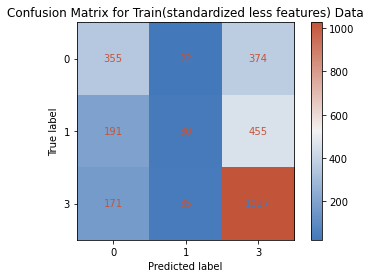

              precision    recall  f1-score   support

           0       0.50      0.47      0.48       751
           1       0.34      0.04      0.08       676
           3       0.55      0.83      0.66      1233

    accuracy                           0.53      2660
   macro avg       0.46      0.45      0.41      2660
weighted avg       0.48      0.53      0.46      2660




In [30]:
# on train data.
y_hat_train_log3
accuracy = accuracy_score(y_train, y_hat_train_log3)
print(f"Accuracy on Train (standardized less features) Data: {accuracy*100:.2f}%")


cmap = sns.diverging_palette(250, 20, as_cmap=True)
plot_confusion_matrix(model3, X_train_less, y_train, cmap=cmap)
plt.title("Confusion Matrix for Train(standardized less features) Data")
plt.show()
print(classification_report(y_train, y_hat_train_log3))

print()

Accuracy on Test Data: 46.84%


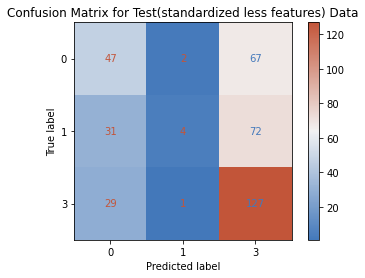

              precision    recall  f1-score   support

           0       0.44      0.41      0.42       116
           1       0.57      0.04      0.07       107
           3       0.48      0.81      0.60       157

    accuracy                           0.47       380
   macro avg       0.50      0.42      0.36       380
weighted avg       0.49      0.47      0.40       380




In [31]:
# on test data.

y_hat_test_log3
accuracy = accuracy_score(y_test, y_hat_test_log3)
print(f"Accuracy on Test Data: {accuracy*100:.2f}%")


cmap = sns.diverging_palette(250, 20, as_cmap=True)
plot_confusion_matrix(model3, X_test_less, y_test, cmap=cmap)
plt.title("Confusion Matrix for Test(standardized less features) Data")
plt.show()
print(classification_report(y_test, y_hat_test_log3))

print()

This model did a little bit better on test data, but very little bit. I think the problem could be non linear relationship. But I'll try to up sample, that in all three classes (win, loss, draw) be the same number of samples.

## 2.6. Logistic regression with upsampled data

In [32]:
counter = Counter(y_train)
print(counter)

Counter({3: 1233, 0: 751, 1: 676})


In [33]:
upsample = SMOTE()
X_train_up, y_train_up = upsample.fit_resample(X_train, y_train)
counter = Counter(y_train_up)
print(counter)
print(X_train_up.shape)

Counter({3: 1233, 0: 1233, 1: 1233})
(3699, 36)


In [34]:
classifier = LogisticRegression(
    C= 0.17551176416426145, penalty= 'l1', solver= 'saga', multi_class='multinomial'
)
model4 = make_pipeline(StandardScaler(), classifier)
scores4 = cross_val_score(model4, X_train_up, y_train_up, cv=cv)
print(f'Accuracy on train data: {scores4.mean()}')
model4.fit(X_train_up, y_train_up)

# Generate model prediction data for train and test sets (standardized)
y_hat_train_log4 = model4.predict(X_train_up)
y_hat_test_log4 = model4.predict(X_test)

Accuracy on train data: 0.4482968369829684


Accuracy on Train (standardized less features) Data: 51.64%


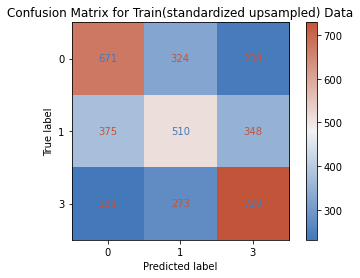

              precision    recall  f1-score   support

           0       0.53      0.54      0.53      1233
           1       0.46      0.41      0.44      1233
           3       0.55      0.59      0.57      1233

    accuracy                           0.52      3699
   macro avg       0.51      0.52      0.51      3699
weighted avg       0.51      0.52      0.51      3699




In [35]:
# on train data.
y_hat_train_log4
accuracy = accuracy_score(y_train_up, y_hat_train_log4)
print(f"Accuracy on Train (standardized less features) Data: {accuracy*100:.2f}%")


cmap = sns.diverging_palette(250, 20, as_cmap=True)
plot_confusion_matrix(model4, X_train_up, y_train_up, cmap=cmap)
plt.title("Confusion Matrix for Train(standardized upsampled) Data")
plt.show()
print(classification_report(y_train_up, y_hat_train_log4))

print()

Accuracy on Test Data: 41.84%


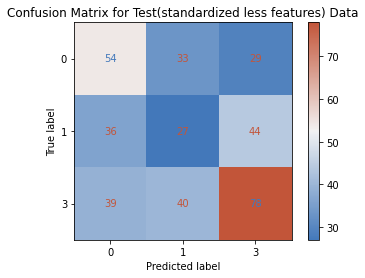

              precision    recall  f1-score   support

           0       0.42      0.47      0.44       116
           1       0.27      0.25      0.26       107
           3       0.52      0.50      0.51       157

    accuracy                           0.42       380
   macro avg       0.40      0.40      0.40       380
weighted avg       0.42      0.42      0.42       380




In [36]:
# on test data.

y_hat_test_log4
accuracy = accuracy_score(y_test, y_hat_test_log4)
print(f"Accuracy on Test Data: {accuracy*100:.2f}%")


cmap = sns.diverging_palette(250, 20, as_cmap=True)
plot_confusion_matrix(model4, X_test, y_test, cmap=cmap)
plt.title("Confusion Matrix for Test(standardized less features) Data")
plt.show()
print(classification_report(y_test, y_hat_test_log4))

print()

Upsampling did not help and the performance of the model is even worse.

## 2.7. K - nearest neighbors classifier

* Searching for hyperparameters to the model.

In [38]:
# using the same data sets.
X_temp
y_temp

# define model
knn = KNeighborsClassifier()

# define evaluation
cv = TimeSeriesSplit(
    n_splits=8,
    gap=0,
    max_train_size=None,
    test_size=None,
)
# define search space
space = dict()
space["n_neighbors"] = [1, 5, 10, 15, 20, 30, 40, 100]
space["weights"] = ["uniform", "distance"]
space["algorithm"] = ["auto", "ball_tree", "kd_tree", "brute"]


# define search
search = RandomizedSearchCV(
    knn, space, n_iter=500, scoring="accuracy", n_jobs=-1, cv=cv, random_state=1
)
# execute search
result = search.fit(X_temp, y_temp)
# summarize result
print("Best Score: %s" % result.best_score_)
print("Best Hyperparameters: %s" % result.best_params_)

Best Score: 0.48590504451038574
Best Hyperparameters: {'weights': 'uniform', 'n_neighbors': 100, 'algorithm': 'auto'}


In [39]:
knn = KNeighborsClassifier(weights = 'uniform', n_neighbors= 100, algorithm = 'auto')
model5 = make_pipeline(StandardScaler(), knn)
scores5 = cross_val_score(model5, X_train, y_train, cv=cv)
print(f'Accuracy on train data with KNN: {scores5.mean()}')

Accuracy on train data with KNN: 0.5186440677966102


In [40]:
model5.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=100))])

In [41]:
# Generate model prediction data for train and test sets KNN
y_hat_train_log5 = model5.predict(X_train)
y_hat_test_log5 = model5.predict(X_test)

* Evaluating KNN Model Performance

KNN Accuracy on Train Data: 53.27%


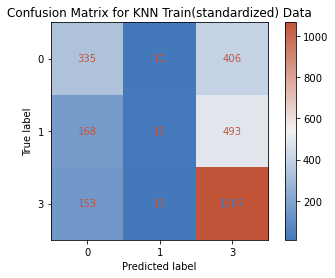

              precision    recall  f1-score   support

           0       0.51      0.45      0.48       751
           1       0.39      0.02      0.04       676
           3       0.54      0.87      0.67      1233

    accuracy                           0.53      2660
   macro avg       0.48      0.44      0.40      2660
weighted avg       0.50      0.53      0.45      2660




In [42]:
# on train data.
y_hat_train_log5
accuracy = accuracy_score(y_train, y_hat_train_log5)
print(f"KNN Accuracy on Train Data: {accuracy*100:.2f}%")


cmap = sns.diverging_palette(250, 20, as_cmap=True)
plot_confusion_matrix(model5, X_train, y_train, cmap=cmap)
plt.title("Confusion Matrix for KNN Train(standardized) Data")
plt.show()
print(classification_report(y_train, y_hat_train_log5))

print()

KNN Accuracy on Test Data: 46.05%


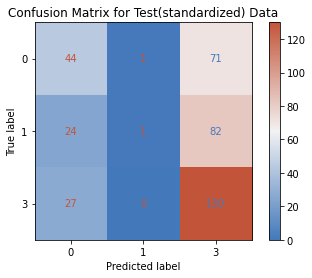

              precision    recall  f1-score   support

           0       0.46      0.38      0.42       116
           1       0.50      0.01      0.02       107
           3       0.46      0.83      0.59       157

    accuracy                           0.46       380
   macro avg       0.47      0.41      0.34       380
weighted avg       0.47      0.46      0.38       380




In [43]:
# on test data.

y_hat_test_log5
accuracy = accuracy_score(y_test, y_hat_test_log5)
print(f"KNN Accuracy on Test Data: {accuracy*100:.2f}%")


cmap = sns.diverging_palette(250, 20, as_cmap=True)
plot_confusion_matrix(model5, X_test, y_test, cmap=cmap)
plt.title("Confusion Matrix for Test(standardized) Data")
plt.show()
print(classification_report(y_test, y_hat_test_log5))

print()

Overall the performance is quite similar.

# 3. Predicting the number of goals by home and away teams

In [44]:
england_df.head()

,country_id,league_name,season,game_date,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,home_team_goal,away_team_goal,home_team_points,away_team_points,result_by_home_team,home_team_goals_last_game,home_team_conceded_goals_last_game,away_team_goal_last_game,away_team_conceded_goals_last_game,home_team_points_last_game,away_team_points_last_game,avg_home_team_goals_by_season_per_game,avg_home_team_goals_in_total_per_game,avg_home_team_conceded_goals_by_season_per_game,avg_home_team_conceded_goals_in_total_per_game,avg_home_team_goals_per_last_3_games,avg_home_team_conceded_goals_per_last_3_games,avg_away_team_goals_by_season_per_game,avg_away_team_goals_in_total_per_game,avg_away_team_conceded_goals_by_season_per_game,avg_away_team_conceded_goals_in_total_per_game,avg_away_team_goals_per_last_3_games,avg_away_team_conceded_goals_per_last_3_games,sum_home_points_by_season_until_this_game,sum_away_points_by_season_until_this_game,avg_home_shot_on,avg_home_shot_off,avg_away_shot_on,avg_away_shot_off,home_chanceCreationPassing,home_chanceCreationCrossing,home_chanceCreationShooting,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth
0,1729,England Premier League,2008/2009,2008-08-16,489043,9825,Arsenal,8659,West Bromwich Albion,1,0,3,0,3,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,7.44,6.55,5.55,5.68,34.67,46.33,46.50,50.50,46.50,50.50,53.00,56.00,54.67,43.00,45.67,54.83
1,1729,England Premier League,2008/2009,2008-08-16,489044,8472,Sunderland,8650,Liverpool,0,1,0,3,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.04,5.44,7.72,7.23,56.67,55.33,59.00,43.67,52.17,51.83,41.33,47.83,57.33,51.00,52.50,56.00
2,1729,England Premier League,2008/2009,2008-08-16,489045,8654,West Ham United,8528,Wigan Athletic,2,1,3,0,3,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.78,5.76,6.01,6.16,50.33,65.50,40.50,32.50,42.83,40.17,52.67,55.50,45.50,50.00,54.00,46.00
3,1729,England Premier League,2008/2009,2008-08-16,489047,8668,Everton,8655,Blackburn Rovers,2,3,0,3,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,6.55,5.80,5.39,5.23,48.17,58.00,49.83,48.33,57.50,56.33,57.00,56.00,42.00,45.67,55.00,46.67
4,1729,England Premier League,2008/2009,2008-08-16,489048,8549,Middlesbrough,8586,Tottenham Hotspur,2,1,3,0,3,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.54,6.14,7.67,6.84,51.00,59.50,56.00,39.33,47.00,42.83,49.83,59.33,62.33,51.17,50.00,55.00


* Target variables (numerical):
- home_team_goal	
- away_team_goal

## 3.1. Assumptions for linear regression

* 1. *Linearity*

Linear regression needs the relationship between the independent and dependent variables to be linear. 

In [4]:
eng_goals_df = england_df.copy()
eng_goals_df.drop(
    columns=[
        "country_id",
        "league_name",
        "season",
        "game_date",
        "match_api_id",
        "home_team_api_id",
        "home_team",
        "away_team_api_id",
        "away_team",
        "result_by_home_team",
        "home_team_points",
        "away_team_points",
    ],
    axis=1,
    inplace=True,
)

In [46]:
eng_goals_df.head()

,home_team_goal,away_team_goal,home_team_goals_last_game,home_team_conceded_goals_last_game,away_team_goal_last_game,away_team_conceded_goals_last_game,home_team_points_last_game,away_team_points_last_game,avg_home_team_goals_by_season_per_game,avg_home_team_goals_in_total_per_game,avg_home_team_conceded_goals_by_season_per_game,avg_home_team_conceded_goals_in_total_per_game,avg_home_team_goals_per_last_3_games,avg_home_team_conceded_goals_per_last_3_games,avg_away_team_goals_by_season_per_game,avg_away_team_goals_in_total_per_game,avg_away_team_conceded_goals_by_season_per_game,avg_away_team_conceded_goals_in_total_per_game,avg_away_team_goals_per_last_3_games,avg_away_team_conceded_goals_per_last_3_games,sum_home_points_by_season_until_this_game,sum_away_points_by_season_until_this_game,avg_home_shot_on,avg_home_shot_off,avg_away_shot_on,avg_away_shot_off,home_chanceCreationPassing,home_chanceCreationCrossing,home_chanceCreationShooting,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth
0,1,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,7.44,6.55,5.55,5.68,34.67,46.33,46.50,50.50,46.50,50.50,53.00,56.00,54.67,43.00,45.67,54.83
1,0,1,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.04,5.44,7.72,7.23,56.67,55.33,59.00,43.67,52.17,51.83,41.33,47.83,57.33,51.00,52.50,56.00
2,2,1,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.78,5.76,6.01,6.16,50.33,65.50,40.50,32.50,42.83,40.17,52.67,55.50,45.50,50.00,54.00,46.00
3,2,3,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,6.55,5.80,5.39,5.23,48.17,58.00,49.83,48.33,57.50,56.33,57.00,56.00,42.00,45.67,55.00,46.67
4,2,1,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,5.54,6.14,7.67,6.84,51.00,59.50,56.00,39.33,47.00,42.83,49.83,59.33,62.33,51.17,50.00,55.00


* Relationship with home_team_goal:

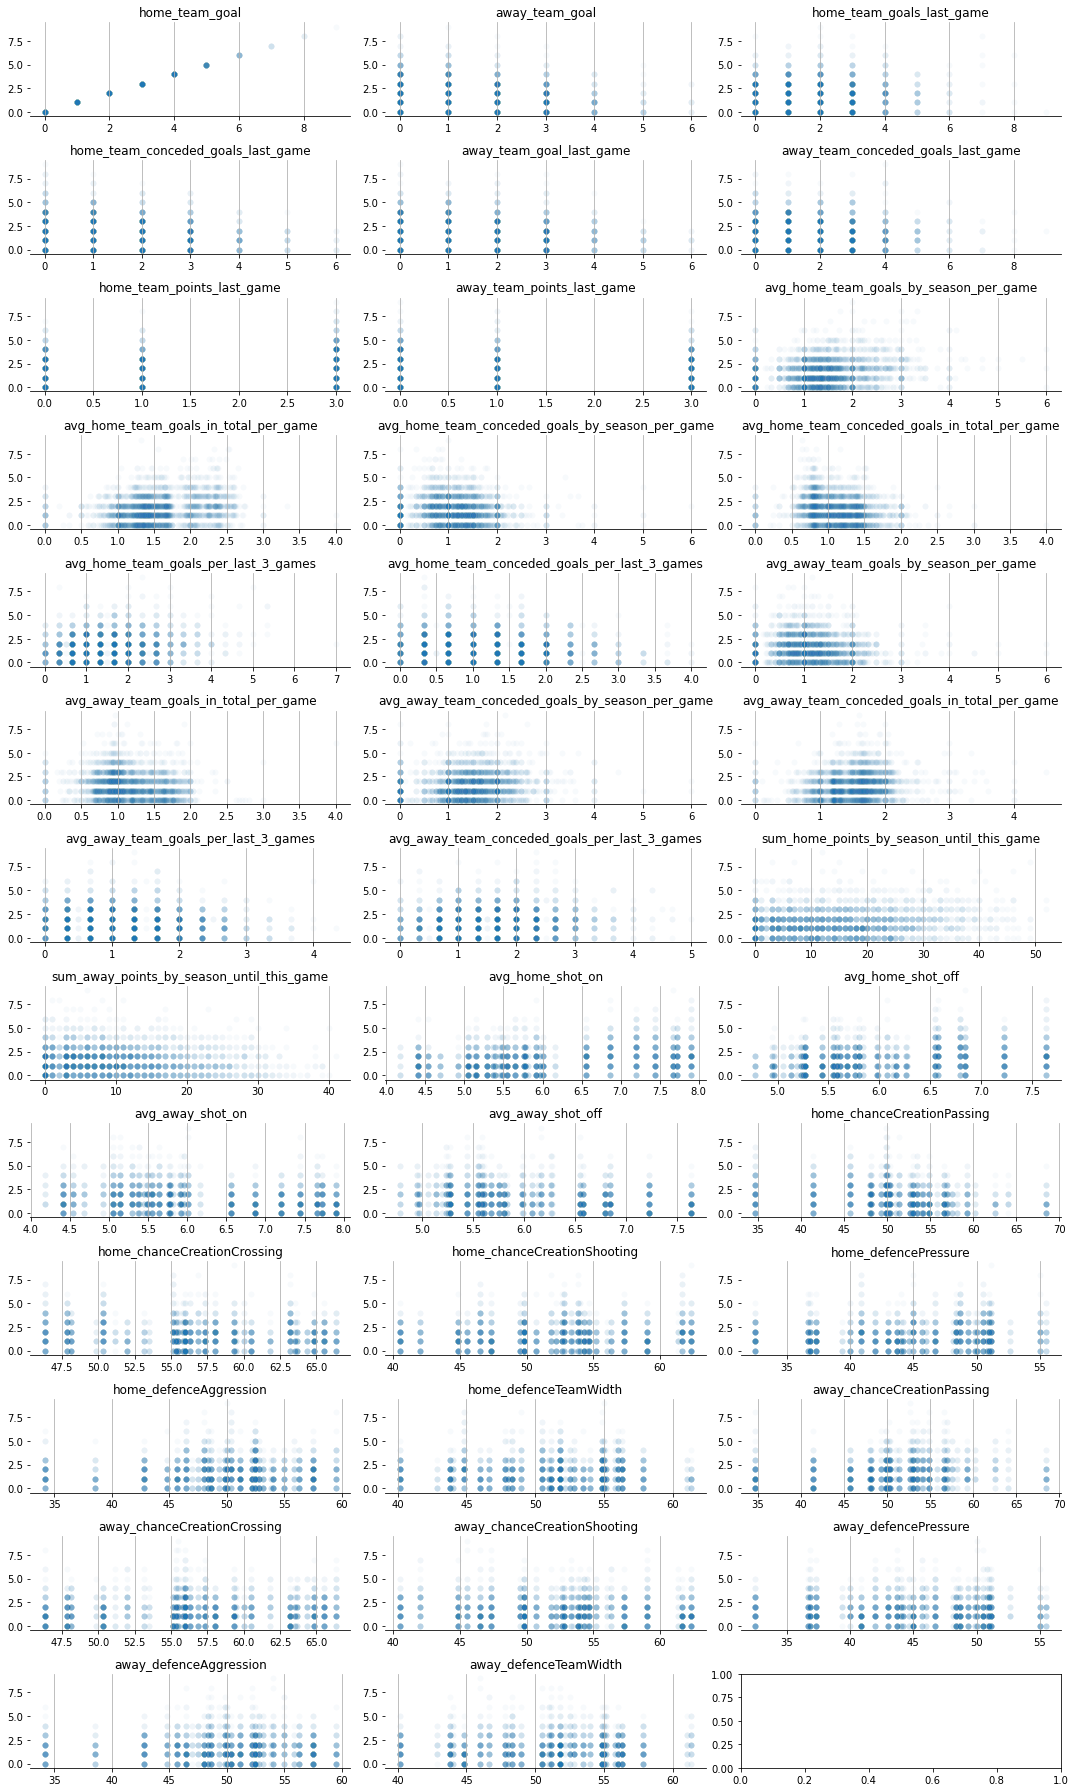

In [47]:
plt.figure(figsize = (15,25))
for i in range(1, len(england_df.columns)):
    try:
        plt.subplot(13, 3, i)
        ax = sns.scatterplot(x=eng_goals_df.columns[i-1],
                        y="home_team_goal",
                        data=eng_goals_df,
                        alpha=0.03,
                        palette='GnBu')
        ax.xaxis.grid(True)
        ax.set_title(f'{eng_goals_df.columns[i-1]}')
        ax.set(ylabel="")
        ax.set(xlabel="")
        plt.tight_layout()
        sns.despine(right=True, left=True)
    except IndexError:
            break
plt.show()

* Relationship with away_team_goal:

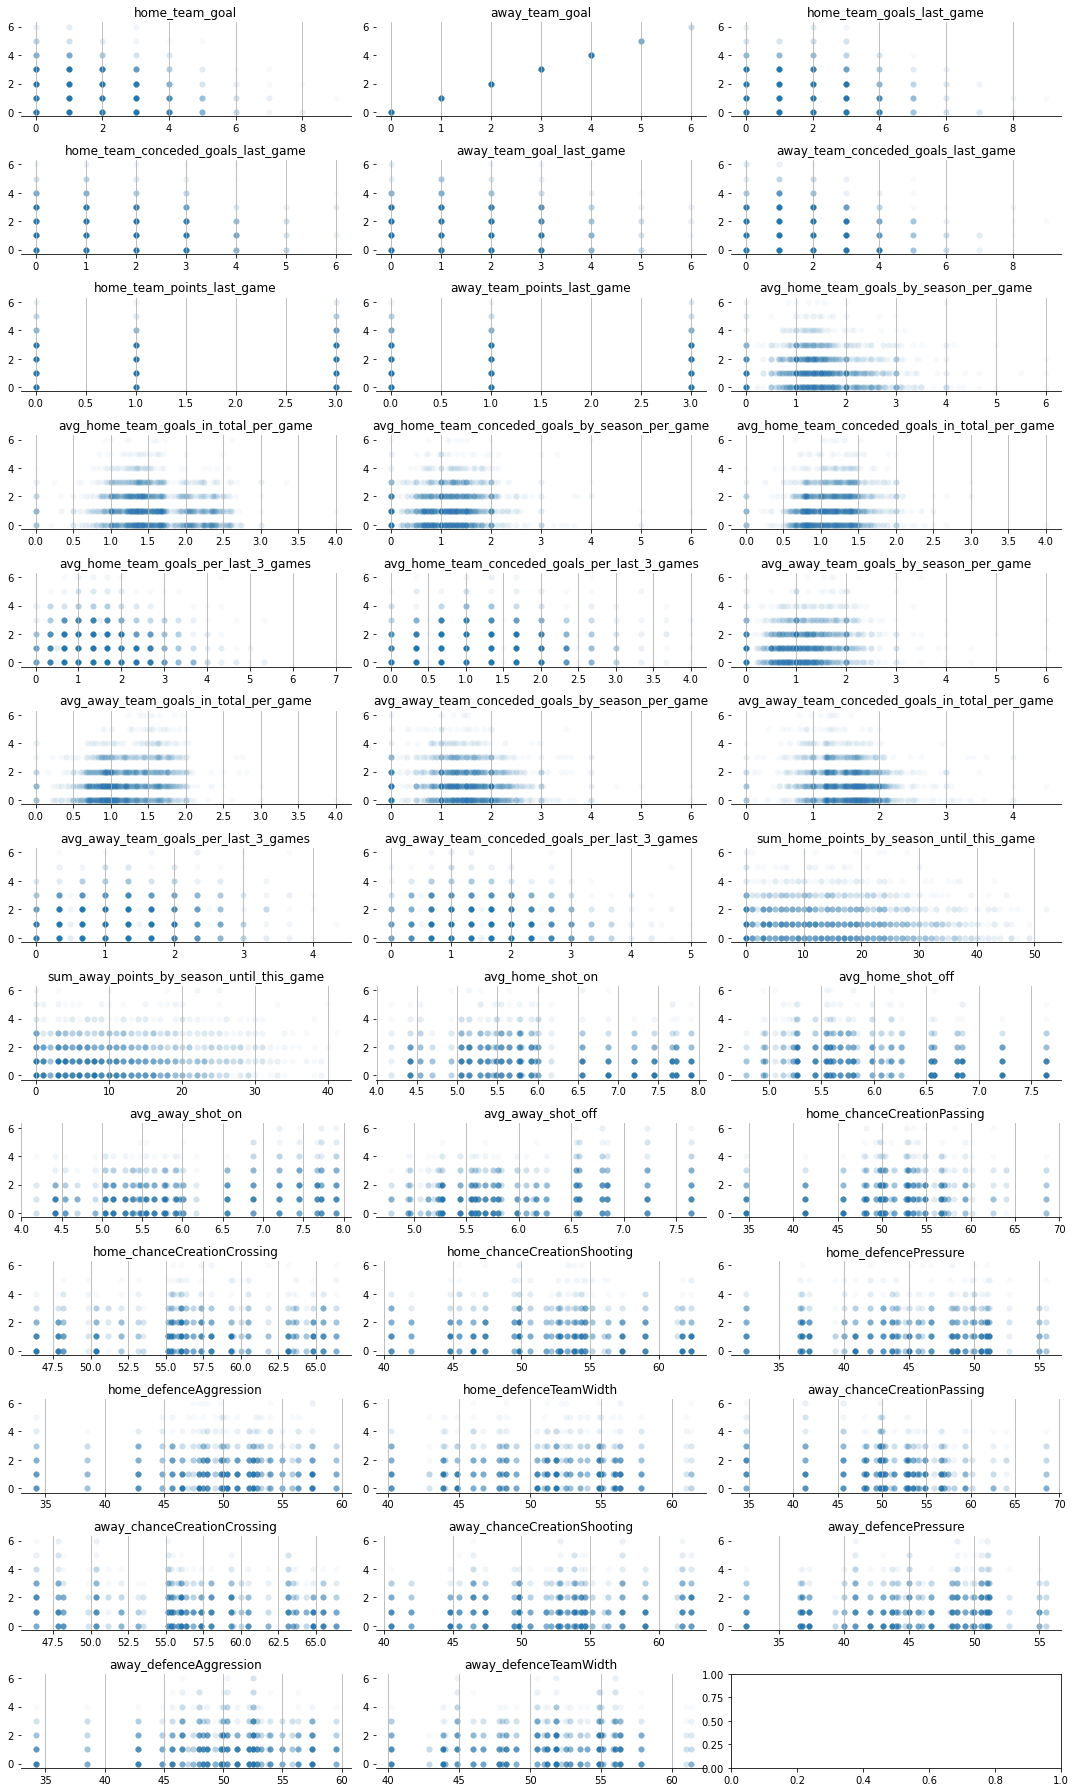

In [48]:
plt.figure(figsize = (15,25))
for i in range(1, len(england_df.columns)):
    try:
        plt.subplot(13, 3, i)
        ax = sns.scatterplot(x=eng_goals_df.columns[i-1],
                        y="away_team_goal",
                        data=eng_goals_df,
                        alpha=0.03,
                        palette='GnBu')
        ax.xaxis.grid(True)
        ax.set_title(f'{eng_goals_df.columns[i-1]}')
        ax.set(ylabel="")
        ax.set(xlabel="")
        plt.tight_layout()
        sns.despine(right=True, left=True)
    except IndexError:
            break
plt.show()

Actually patterns in most scatter plots doesn't indicate linear relationship between dependent variables and independent variables. Only home team and away team goals, seem to have negative linear relationship. 
It's hard to interpret a linear relationship with so many independent variables.

* 2. *Variables follow a Normal Distribution*

From the EDA chapter 3.3. distribution plots we may see that distributions of most features are right skewed, exponential, also values are in different ranges and even scales, so feature scaling must be applied. 

* 3. *Absence of multicollinearity*

In this scenario, I assumed that any features with a correlation coefficient exceeding 0.80 are suspected of causing multicollinearity. From EDA in chapter 3.3 and the heatmap of Pearson's correlation coefficients we see that no features correlation coefficients reach or exceed 0.8.

## 3.2. Feature pre-processing

In [49]:
df_goals = england_df.copy()

* Target: home_team_goal.

In [5]:
# Identify and drop our target variable 'home_team_goal' from dataframe, isolating our independent variables
X = df_goals.drop(columns=["home_team_goal", "away_team_goal"], axis=1)

# Isolate our dependent variable as a feature
y_h = df_goals.home_team_goal
y_a = df_goals.away_team_goal

As I have data, ordered by the match date and the order is important, not to give predict on future matches data,
I split dataset manually. Drop unneeded columns after splitting.

In [6]:
X_test = X[X["season"] == "2015/2016"]
X_test.drop(
    columns=[
        "country_id",
        "league_name",
        "season",
        "game_date",
        "match_api_id",
        "home_team_api_id",
        "home_team",
        "away_team_api_id",
        "away_team",
        "home_team_points",
        "result_by_home_team",
        "away_team_points",
    ],
    axis=1,
    inplace=True,
)
y_h_test = y_h.iloc[2660:]
y_a_test = y_a.iloc[2660:]

In [7]:
X_train = X[X["season"] != "2015/2016"]
X_train.drop(
    columns=[
        "country_id",
        "league_name",
        "season",
        "game_date",
        "match_api_id",
        "home_team_api_id",
        "home_team",
        "away_team_api_id",
        "away_team",
        "home_team_points",
        "result_by_home_team",
        "away_team_points",
    ],
    axis=1,
    inplace=True,
)
y_h_train = y_h.iloc[:2660]
y_a_train = y_a.iloc[:2660]

In [53]:
print(X_train.shape)
print(X_test.shape)
print(y_h_train.shape)
print(y_h_test.shape)
print(y_a_train.shape)
print(y_a_test.shape)

(2660, 36)
(380, 36)
(2660,)
(380,)
(2660,)
(380,)


## 3.3. Linear regression for predicting home goals

In [8]:
cv = TimeSeriesSplit(n_splits=8, gap=0, max_train_size=None, test_size=None,)
regressor = LinearRegression()
pipe = make_pipeline(StandardScaler(), regressor)
scores = cross_val_score(
    pipe, X_train, y_h_train, scoring="neg_mean_squared_error", cv=cv, n_jobs=1
)

print(
    "Folds: "
    + str(len(scores))
    + ", MSE: "
    + str(np.mean(np.abs(scores)))
    + ", RMSE: "
    + str(np.sqrt(np.mean(np.abs(scores))))
    + ", STD: "
    + str(np.std(scores))
)

It seems that this model is doing quite good, MSE is quite low.

In [55]:
pipe.fit(X_train, y_h_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [56]:
# predict future values
y_h_hat_train = pipe.predict(X_train)
y_h_hat_test = pipe.predict(X_test)

In [9]:
# Coefficients.
coeff_parameter = pd.DataFrame(
    pipe.named_steps["linearregression"].coef_, X_train.columns, columns=["Coefficient"]
)
coeff_parameter

My coefficients are very very small and it seems that my selected features doesn't give a chance to predict something and do not show relationship between independent variable and predictors.

In [58]:
# Print respective output scores
print(f"r^2: {r2_score(y_h_train, y_h_hat_train)}")
print(f"rmse: {np.sqrt(mean_squared_error(y_h_train, y_h_hat_train))}")

r^2: 0.1252203673386314
rmse: 1.2333696467385613


In [59]:
# Print respective output scores
print(f"r^2: {r2_score(y_h_test, y_h_hat_test)}")
print(f"rmse: {np.sqrt(mean_squared_error(y_h_test, y_h_hat_test))}")

r^2: 0.05837075951271731
rmse: 1.2203287647917362


R Square is a relative measure of how well the model fits dependent variables.
So, only 12 % of the variability in the scored home team goals feature can be explained by this model with included all my selected independent features (the training data) and about 5% in the new to the model - test data. So clearly my model is underfitting the data.

RMSE is a measure of accuracy, like the standard deviation of residuals. RMSE is the square root of the average of squared errors. Value of 0 (almost never achieved in practice) would indicate a perfect fit to the data. In my way RMSE is over 1, so clearly underfitting the data.

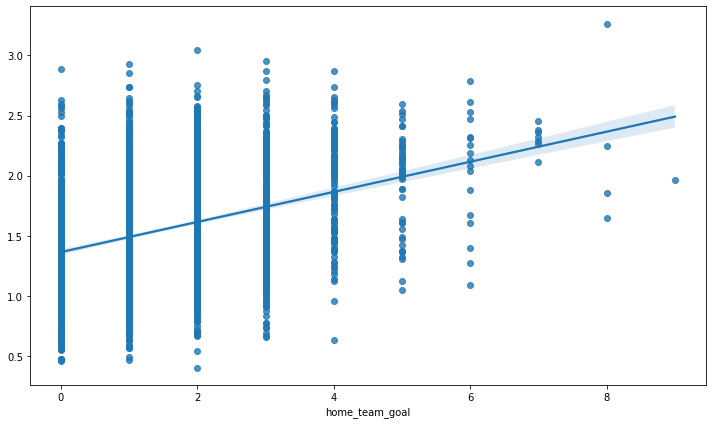

In [60]:
# Real values vs. predicted values in the train set
plt.figure(figsize = (10,6))
sns.regplot(x=y_h_train,y=y_h_hat_train)

plt.tight_layout();

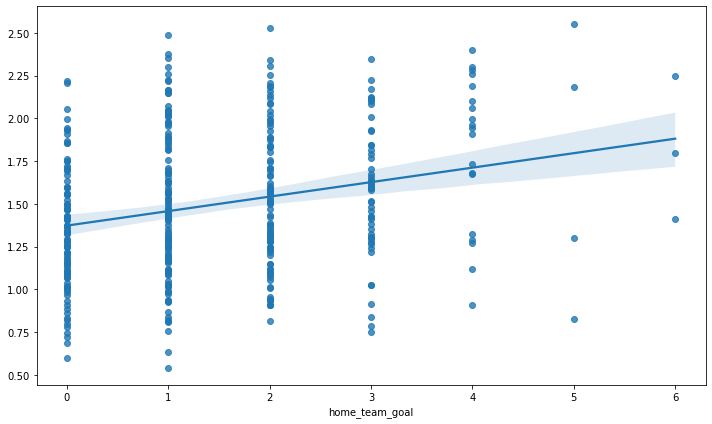

In [61]:
# Real values vs. predicted values in the test set
plt.figure(figsize = (10,6))
sns.regplot(x=y_h_test,y=y_h_hat_test)

plt.tight_layout();

#### *Assumptions, looked after model training*



* 4. *Residuals are Normally Distributed (Homescedasticity)*

The variance of residuals. Y values should be the same not depending low or high x values.

In [62]:
residuals = y_h_hat_train - y_h_train

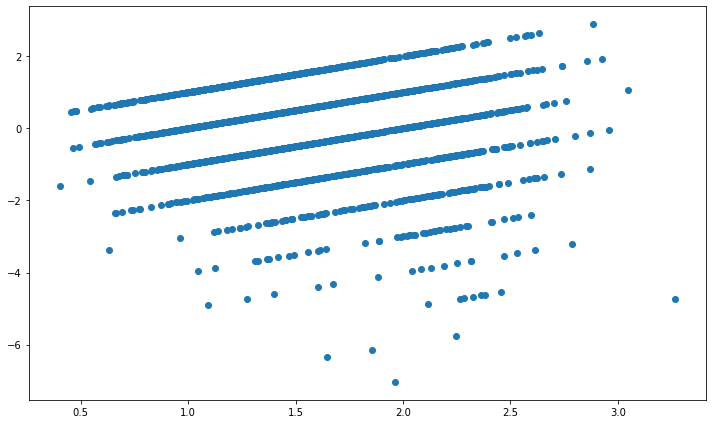

In [63]:
plt.figure(figsize = (10,6))
plt.scatter(y_h_hat_train, residuals)
plt.tight_layout()

In [64]:
residuals2 = y_h_hat_test - y_h_test

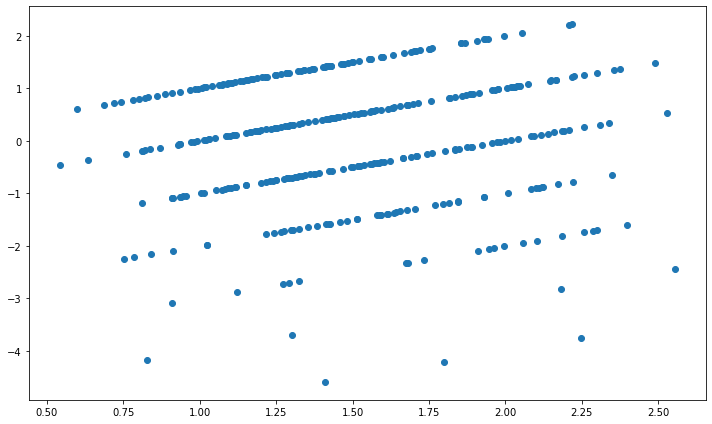

In [65]:
plt.figure(figsize = (10,6))
plt.scatter(y_h_hat_test, residuals2)
plt.tight_layout()

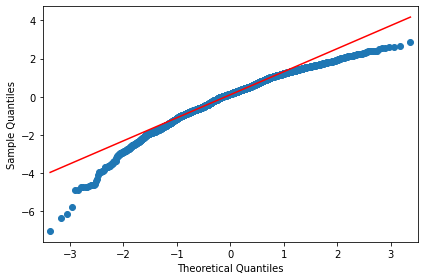

In [66]:
t = qqplot(residuals, line = 'q')
plt.tight_layout()

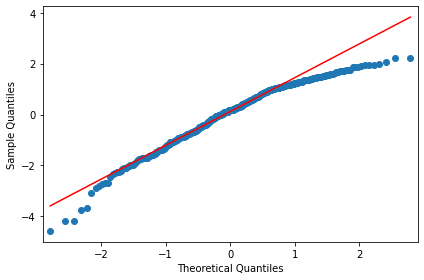

In [67]:
t = qqplot(residuals2, line = 'q')
plt.tight_layout()

Residuals are not normally distributed, as we may see from the qq plots of the residuals, in the lower and upper side we have them quite far from the theoretical line. Also it may be some kind of pattern in the scatter plots.

* 5. *No Autocorrelation in residuals*

In [68]:
#perform Durbin-Watson test
durbin_watson(residuals)

1.9989715393711878

Use Durbin-Watson Test.
DW = 2 would be the ideal case here (no autocorrelation);
0 < DW < 2 -> positive autocorrelation;
2 < DW < 4 -> negative autocorrelation.
Autocorrelation occurs when the residuals are not independent of each other. In this model we see, that there's no autocorrelation between residuals, the durbin_watson test result is very close to 2.

* 6. *Expectation (mean) of residuals is zero*

In [70]:
residuals.mean()

1.8297811052468745e-16

Mean of residuals looks quite small, close to zero.

To conclude, it seems that the linear regression model doesn't fit our data at all. So lets' try the polynomial regression, as from scatter plots we see that some features relate to non linear relationship.

## 3.4. Polynomial regression for predicting away goals

In [73]:
cv = TimeSeriesSplit(
    n_splits=8,
    gap=0,
    max_train_size=None,
    test_size=None,
)

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_train) 
regressor2 = LinearRegression()
pipe2 = make_pipeline(StandardScaler(), regressor2)
scores = cross_val_score(pipe2, poly_features, y_a_train, scoring="neg_mean_squared_error", cv=cv, n_jobs=1)

print("Folds: " + str(len(scores)) + ", MSE: " + str(np.mean(np.abs(scores))) + ", RMSE: " + str(np.sqrt(np.mean(np.abs(scores)))) + ", STD: " + str(np.std(scores)))


Folds: 8, MSE: 9.400470967664714e+18, RMSE: 3066018748.7464447, STD: 1.5860227449666386e+19


The MSE and RMSE are huge. I think I should select less features to use and to turn into polynomial, according to the scatter plots and to the linear regression, used to predict home team goals.

In [72]:
X_train_less_features = X_train[['home_team_goals_last_game', 'home_team_conceded_goals_last_game', 
'away_team_goal_last_game','away_team_conceded_goals_last_game', 
'avg_home_team_conceded_goals_per_last_3_games',
'avg_away_team_goals_in_total_per_game',
'avg_away_team_goals_per_last_3_games',
'avg_away_shot_on',
'avg_away_shot_off']]
X_test_less_features = X_test[['home_team_goals_last_game', 'home_team_conceded_goals_last_game', 
'away_team_goal_last_game','away_team_conceded_goals_last_game', 
'avg_home_team_conceded_goals_per_last_3_games',
'avg_away_team_goals_in_total_per_game',
'avg_away_team_goals_per_last_3_games',
'avg_away_shot_on',
'avg_away_shot_off']]

In [79]:
cv = TimeSeriesSplit(
    n_splits=8,
    gap=0,
    max_train_size=None,
    test_size=None,
)

degree = [2,3, 4, 5]
for i in degree:
    poly = PolynomialFeatures(degree=i, include_bias=False)
    poly_features = poly.fit_transform(X_train_less_features) 
    regressor3 = LinearRegression()
    pipe3 = make_pipeline(StandardScaler(), regressor3)
    scores3 = cross_val_score(pipe3, poly_features, y_a_train, scoring="neg_mean_squared_error", cv=cv, n_jobs=1)

    print("Degree: " + str(i) + ", Folds: " + str(len(scores3)) + ", MSE: " + str(np.mean(np.abs(scores3))) + ", RMSE: " + str(np.sqrt(np.mean(np.abs(scores3)))) + ", STD: " + str(np.std(scores3)))


Degree: 2, Folds: 8, MSE: 1.306345967876409, RMSE: 1.1429549281911378, STD: 0.12559045534128385
Degree: 3, Folds: 8, MSE: 6.048487979081527, RMSE: 2.4593673940835936, STD: 10.666171579822889
Degree: 4, Folds: 8, MSE: 480.13256224961026, RMSE: 21.91192739695918, STD: 881.5553094756024
Degree: 5, Folds: 8, MSE: 20167076.561202012, RMSE: 4490.776832709683, STD: 53210428.45646423


In [80]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_train_less_features) 
regressor4 = LinearRegression()
pipe4 = make_pipeline(StandardScaler(), regressor3)
pipe4.fit(X_train_less_features, y_a_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [81]:
# predict future values
y_a_hat_train = pipe4.predict(X_train_less_features)
y_a_hat_test = pipe4.predict(X_test_less_features)

In [82]:
# Coefficients.
coeff_parameter = pd.DataFrame(pipe4.named_steps['linearregression'].coef_,X_train_less_features.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
home_team_goals_last_game,-0.05
home_team_conceded_goals_last_game,0.02
away_team_goal_last_game,0.00
away_team_conceded_goals_last_game,0.00
avg_home_team_conceded_goals_per_last_3_games,0.07
avg_away_team_goals_in_total_per_game,0.05
avg_away_team_goals_per_last_3_games,0.03
avg_away_shot_on,0.22
avg_away_shot_off,0.03


My coefficients are very very small even with less features and it seems that my selected features doesn't give a chance to predict something.

In [83]:
# Print respective output scores
print(f"r^2: {r2_score(y_a_train, y_a_hat_train)}")
print(f"rmse: {np.sqrt(mean_squared_error(y_a_train, y_a_hat_train))}")

r^2: 0.07486578937057808
rmse: 1.100469232826191


In [84]:
# Print respective output scores
print(f"r^2: {r2_score(y_a_test, y_a_hat_test)}")
print(f"rmse: {np.sqrt(mean_squared_error(y_a_test, y_a_hat_test))}")

r^2: 0.03576048746782923
rmse: 1.124777151842846


So, only 3 (new data) and 7(train data) % of the variability in the away goal score feature can be explained by this model with included all my selected independent features (the training data) .

RMSE is a measure of accuracy, like the standard deviation of residuals. RMSE is the square root of the average of squared errors. Value of 0 (almost never achieved in practice) would indicate a perfect fit to the data. In my way RMSE is over 1, so clearly underfitting the data.

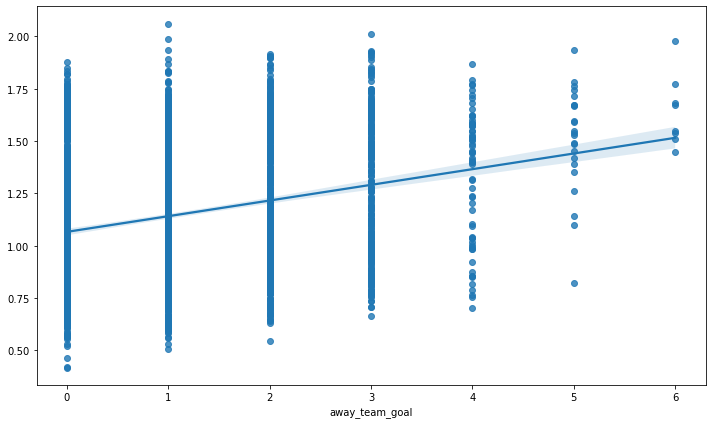

In [85]:
# Real values vs. predicted values in the train set
plt.figure(figsize = (10,6))
sns.regplot(x=y_a_train,y=y_a_hat_train)

plt.tight_layout();

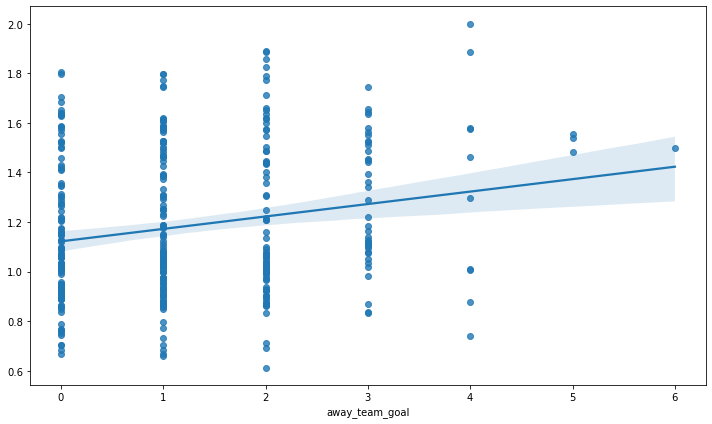

In [86]:
# Real values vs. predicted values in the test set
plt.figure(figsize = (10,6))
sns.regplot(x=y_a_test,y=y_a_hat_test)

plt.tight_layout();

So still, with these selected features I cannot predict the result of the away team scored goals.

# Conclusion

* The result of the football match  can be predicted, but in my research and selected features, I think I concentrated to much on the home/away goals and points scored playing in these different fields. I divided all teams into home and away and counted only their scored goals, for example playing at home and away, I totally separated these matches. Thats wasn't a good idea as my features, according to the coefficients of the models, aren't actually important. 
* There should be selected another dataset of features, including total number of goals, scores, not dividing into home and away matches, but having as separate feature or some kind of weight - home/away match category.
* Also should be selected additional features about all player, that played in the game, as best can score up to 40 proc. of total goals by team in one season. So some players are very important and can indicate higher chance of winning nad more goals scoring in the game.
* There should be included features about last season or two (as we saw some trends of better team performance in couple season and the that team had won the championship), statistics of last performances, statistics of cards, shots on and shots off, possession of the ball.
* There is not enough to include and count only on goals,score,shot on and shot off, teams average attributes, to be able to predict match outcome and number of scored goals.